In [37]:
from utils.experiment_utils import get_all_experiments_info, load_best_model
import torch
import os
import hydra
from omegaconf import DictConfig, OmegaConf

import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product

import ternary

In [29]:
device = 'cuda'
configs = get_all_experiments_info('outputs/', False)
cfgs = [c for c in configs if 'mnist_multinomial' in c['name']]

In [7]:
alphas = [c['config']['dataset']['alpha'] for c in cfg]

In [ ]:
def simplex_grid(dim, points_per_dim):
    lin = np.linspace(0, 1, points_per_dim)
    grid = np.array(list(product(*([lin] * dim))))
    grid = grid[np.isclose(grid.sum(axis=1), 1)]  # keep only rows that sum to 1
    return grid

def prepare_dataset(dataset_cfg, points_per_dim, set_size=100):
    probs = simplex_grid(dataset_cfg['n_classes'], points_per_dim)
    dataset = hydra.utils.instantiate(dataset_cfg)
    dataset.custom_probs = probs
    dataset.set_size = set_size
    dataset.n_sets = len(probs)
    dataset.data, dataset.metadata, dataset.prob = dataset.make_sets()
    return dataset

# load encoder and move to device
def load_encoder(cfg, path, device):
    enc = hydra.utils.instantiate(cfg)
    state = load_best_model(path)
    enc.load_state_dict(state['encoder_state_dict'])
    enc.eval()
    enc.to(device)
    return enc

def batched_dists(dataset, encoder, batch_size=8, device='cuda'):

    with torch.no_grad():
        fr = torch.tensor(dataset.fisher_rao_distance(np.array(dataset.prob)))
        x_all = torch.tensor(dataset.data, dtype=torch.float32)

        zs = []
        for i in range(0, x_all.size(0), batch_size):
            x_chunk = x_all[i:i+batch_size].to(device)
            z_chunk = encoder(x_chunk).cpu()  # offload!
            zs.append(z_chunk)
        z = torch.cat(zs, dim=0).to(device)  # full z back on gpu :)

    return fr, torch.cdist(z, z, p=2)

loading configs and models...
processing cfg 1/3


/orcd/data/omarabu/001/gokul/DistributionEmbeddings/datasets/mnist.py:199: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(self.mnist.targets)
/tmp/ipykernel_750976/4081018806.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_all = torch.tensor(dataset.data, dtype=torch.float32)


processing cfg 2/3
processing cfg 3/3


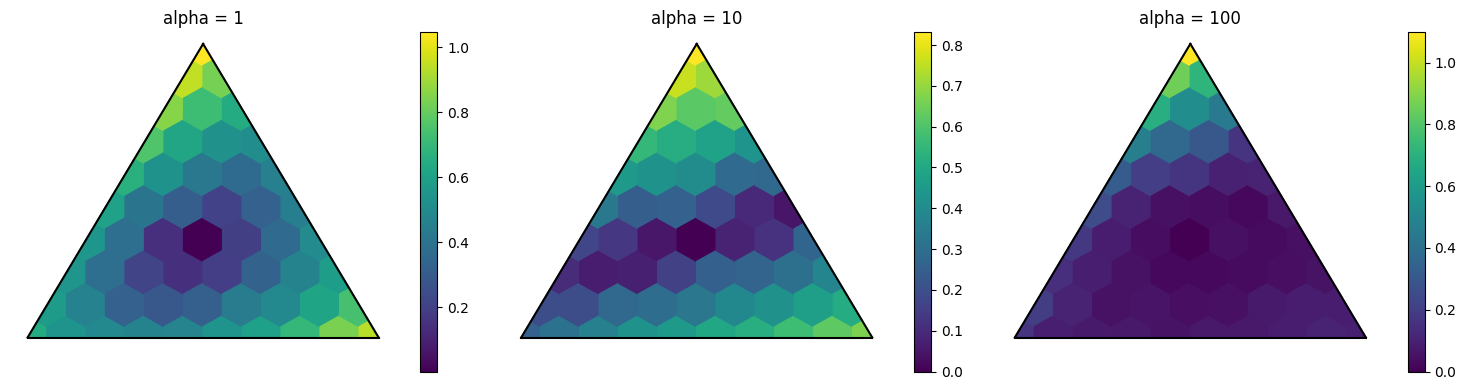

In [115]:
points_per_dim = 10
set_size = 1000
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('loading configs and models...')

fig, axs = plt.subplots(1, len(cfgs), figsize=(5 * len(cfgs), 4))

for i, cfg in enumerate(cfgs):
    print(f'processing cfg {i+1}/{len(cfgs)}')

    encoder = load_encoder(cfg['config']['encoder'], cfg['dir'], device)
    dataset_cfg = cfg['config']['dataset']
    dataset = prepare_dataset(dataset_cfg, points_per_dim, set_size)
    fr, dists = batched_dists(dataset, encoder, device=device, batch_size=1)
    dists = dists.cpu().numpy()

    scale = 9
    prob_tuples = [tuple(np.round(s*scale)) for s in dataset.custom_probs]
    anchor_idx = prob_tuples.index((3,3,3))
    colors = dists[anchor_idx]
    simplex_d = {prob_tuples[j]: colors[j] for j in range(len(prob_tuples))}

    tax = ternary.TernaryAxesSubplot(ax=axs[i], scale=scale)
    tax.heatmap(simplex_d, style="h")
    tax.boundary()
    tax.clear_matplotlib_ticks()
    tax.get_axes().axis('off')
    tax.set_title(f"alpha = {alphas[i]}")

plt.tight_layout()
plt.show()

processing cfg 1/3


/tmp/ipykernel_750976/4081018806.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_all = torch.tensor(dataset.data, dtype=torch.float32)


processing cfg 2/3
processing cfg 3/3


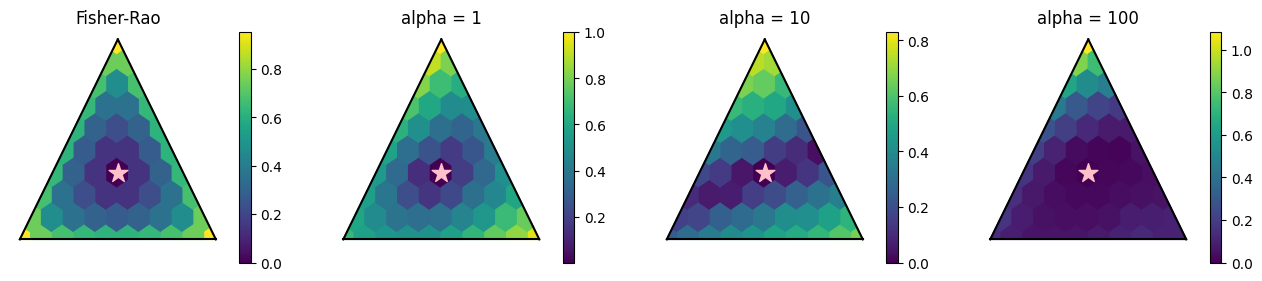

In [129]:
points_per_dim = 10
set_size = 2000

def plot_ternary(ax, dists, dataset, title=None):
    scale = 9
    prob_tuples = [tuple(np.round(s * scale)) for s in dataset.custom_probs]
    anchor_idx = prob_tuples.index((3, 3, 3))  # classic anchor :)
    colors = dists[anchor_idx]
    simplex_d = {prob_tuples[i]: colors[i] for i in range(len(prob_tuples))}

    tax = ternary.TernaryAxesSubplot(ax=ax, scale=scale)
    tax.heatmap(simplex_d, style="h")
    tax.boundary()
    tax.clear_matplotlib_ticks()
    tax.get_axes().axis('off')
    if title:
        tax.set_title(title)

    tax.scatter([prob_tuples[anchor_idx]], marker='*', color='pink', s=200, zorder=10)


fig, axs = plt.subplots(1, len(cfgs)+1, figsize=(4 * (len(cfgs)+1), 3))

for i, cfg in enumerate(cfgs):
    print(f'processing cfg {i+1}/{len(cfgs)}')

    encoder = load_encoder(cfg['config']['encoder'], cfg['dir'], device)
    dataset_cfg = cfg['config']['dataset']
    dataset = prepare_dataset(dataset_cfg, points_per_dim, set_size)
    fr, dists = batched_dists(dataset, encoder, device=device, batch_size=1)
    dists = dists.cpu().numpy()

    plot_ternary(axs[i+1], dists, dataset, title=f"alpha = {alphas[i]}")

    if i == 0:
        plot_ternary(axs[0], fr, dataset, title='Fisher-Rao')